# SEN12 Flood — Notebook d'EDA (Sentinel-1 & Sentinel-2)
- 1 folder : 1 geographical zone
- 1 index : 1 date 

## 🛰️ 1. Sentinel-2 (optical)
#### Revisit time: ~5 days (S2A + S2B)
Limitations:
- cannot see through clouds
- heavily affected by weather
- acquisition sometimes delayed or missing

## 📡 2. Sentinel-1 (radar SAR)
#### Revisit time: ~6 days (S1A + S1B)
Advantages:
- sees through clouds
- works day and night
- unaffected by weather
Because S1 is radar and doesn’t depend on sunlight, it captures images at totally different times compared to S2.

In [15]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import pandas as pd
from PIL import Image

root = Path('/Volumes/Nour/sen12flood/SEN12FLOOD')
print('Root:', root)
print('Exists:', root.exists())

Root: /Volumes/Nour/sen12flood/SEN12FLOOD
Exists: True


## 2) Inventaire des fichiers et création d'un DataFrame
Nous listons les dossiers (patches) et les fichiers .tif associés, puis extrayons des métadonnées basiques (capteur, date, bande).
Ce DataFrame facilite les filtres et les appels de fonctions suivants.

In [16]:
rows = []
if not root.exists():
    raise FileNotFoundError(f'Chemin non trouvé: {root} - exécutez ce notebook localement où le volume est monté')

for folder in sorted(root.iterdir()):
    if not folder.is_dir():
        continue
    folder_id = folder.name
    for tif in folder.glob('*.tif'):
        row = {'folder': folder_id, 'file': tif.name, 'path': tif}
        if tif.name.startswith('S2_'):
            row['sensor'] = 'S2'
            parts = tif.name.split('_')
            if len(parts) >= 3:
                row['date'] = parts[1]
                row['band'] = parts[-1].replace('.tif','')
        elif 'corrected' in tif.name or tif.name.startswith('S1_'):
            row['sensor'] = 'S1'
            row['band'] = 'VV' if 'VV' in tif.name else ('VH' if 'VH' in tif.name else None)
            m = re.search(r'_(\d{8})T', tif.name)
            if m:
                dt = m.group(1)
                row['date'] = f'{dt[0:4]}-{dt[4:6]}-{dt[6:8]}'
        rows.append(row)

df = pd.DataFrame(rows)
print('Found patches:', df.folder.nunique())
df.head()

Found patches: 44


,folder,file,path,sensor,date,band
0,0,S2_2019-02-10_B05.tif,/Volumes/Nour/sen12flood/SEN12FLOOD/0/S2_2019-...,S2,2019-02-10,B05
1,0,S2_2019-02-10_B11.tif,/Volumes/Nour/sen12flood/SEN12FLOOD/0/S2_2019-...,S2,2019-02-10,B11
2,0,S1A_IW_GRDH_1SDV_20190313T161522_20190313T1615...,/Volumes/Nour/sen12flood/SEN12FLOOD/0/S1A_IW_G...,S1,2019-03-13,VV
3,0,S2_2019-01-26_B09.tif,/Volumes/Nour/sen12flood/SEN12FLOOD/0/S2_2019-...,S2,2019-01-26,B09
4,0,S1B_IW_GRDH_1SDV_20190218T160653_20190218T1607...,/Volumes/Nour/sen12flood/SEN12FLOOD/0/S1B_IW_G...,S1,2019-02-18,VH


# 🛰️ Utility Functions for SEN12FLOOD Visualization

This section explains the purpose of the three main utility functions used to prepare and visualize data from the **SEN12FLOOD** dataset:

- `align_band`
- `load_s2_rgb`
- `load_s1`

These functions process **Sentinel-2 (optical)** and **Sentinel-1 (radar)** imagery so they can be displayed reliably and interpreted correctly.

## 1. `align_band`: Reproject and Align a Band to a Reference Band

Different spectral bands may have **slightly different resolutions, shapes, or geospatial transforms**.  
This function ensures all bands line up perfectly.

**What it does:**
- Takes a *reference* band (usually Sentinel-2 B04 – Red)
- Reprojects the *target* band onto the reference geometry
- Ensures both images have the **same CRS, transform, and pixel grid**

**Why it matters:**  
You cannot build a clean RGB image if bands are misaligned.  
Without alignment you may see:
- shifted colors  
- missing regions  
- black corners or distorted images  

`align_band` fixes this.

In [5]:
def align_band(ref_path, target_path):
    # Reproject target to match reference geometry (returns 2D array)
    with rasterio.open(ref_path) as ref:
        ref_data = ref.read(1)
        ref_transform = ref.transform
        ref_crs = ref.crs

    with rasterio.open(target_path) as src:
        src_data = src.read(1)
        dst = np.zeros_like(ref_data, dtype='float32')
        reproject(
            src_data, dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.bilinear
        )
    return dst


## 2. `load_s2_rgb`: Build a True-Color Sentinel-2 Image

Sentinel-2 provides multiple optical spectral bands.  
To create a natural-looking RGB image, we combine:

- **B04 (Red)**
- **B03 (Green)**
- **B02 (Blue)**

**What the function does:**
1. Loads bands B04, B03, B02  
2. Aligns them using `align_band`  
3. Stacks them into an RGB image  
4. Normalizes values (robust percentile scaling)  
5. Optionally produces a thumbnail (`thumb_size`)

**Why it matters:**  
This reconstructs a **true-color image** similar to a regular photograph.  
It is extremely useful for visually identifying:
- water surfaces  
- vegetation  
- soil  
- cloud cover  


In [6]:
def load_s2_rgb(folder_id, date, thumb_size=None):
    folder = root / folder_id
    # Cherche fichiers attendus (format S2_YYYY-MM-DD_B??.tif)
    b2 = next(folder.glob(f'S2_{date}_B02.tif'), None)
    b3 = next(folder.glob(f'S2_{date}_B03.tif'), None)
    b4 = next(folder.glob(f'S2_{date}_B04.tif'), None)
    b8 = next(folder.glob(f'S2_{date}_B08.tif'), None)  # NIR pour NDVI si présent
    if not b2 or not b3 or not b4:
        print('Manque des bandes S2 pour', folder_id, date)
        return None
    # Aligner sur B04 (référence)
    B04 = align_band(b4, b4)
    B03 = align_band(b4, b3)
    B02 = align_band(b4, b2)
    rgb = np.stack([B04, B03, B02], axis=-1).astype('float32')
    # Normalisation par bande via 2e/99e percentiles robustes
    p2 = np.percentile(rgb, 2, axis=(0,1))
    p98 = np.percentile(rgb, 98, axis=(0,1))
    denom = (p98 - p2)
    denom[denom == 0] = 1.0
    rgb = (rgb - p2) / denom
    rgb = np.clip(rgb, 0, 1)
    if thumb_size is not None:
        img_uint8 = (rgb * 255).astype('uint8')
        pil = Image.fromarray(img_uint8)
        pil = pil.resize((thumb_size, thumb_size), resample=Image.BILINEAR)
        rgb = np.asarray(pil).astype('float32') / 255.0
    return rgb, b8

## 3. `load_s1`: Build a Pseudo-RGB Radar Image (VV / VH)

Sentinel-1 is a **radar sensor** (SAR), not an optical camera.  
It measures how much radar energy is reflected back to the satellite.

The dataset provides two polarizations:
- **VV** (Vertical transmit, Vertical receive)
- **VH** (Vertical transmit, Horizontal receive)

**What the function does:**
1. Loads VV and VH backscatter images  
2. Normalizes both bands  
3. Builds a pseudo-RGB composite using:  
   - R = VV  
   - G = VH  
   - B = VV × VH  

**Why it matters:**  
Radar is extremely powerful for flood detection because it works:
- at night  
- through clouds and storms  
- regardless of sunlight  

Water surfaces produce **very dark radar responses**, while rough surfaces (buildings, vegetation) appear much brighter.

In [7]:
def load_s1(folder_id, date, thumb_size=None):
    folder = root / folder_id
    date_compact = date.replace('-', '') if '-' in date else date
    vv = next(folder.glob(f'*{date_compact}*VV*.tif'), None)
    vh = next(folder.glob(f'*{date_compact}*VH*.tif'), None)
    if not vv or not vh:
        print('Manque des bandes S1 pour', folder_id, date)
        return None
    with rasterio.open(vv) as s: VV = s.read(1).astype('float32')
    with rasterio.open(vh) as s: VH = s.read(1).astype('float32')
    # Normaliser 0-1 par percentiles
    def norm(a):
        a = np.nan_to_num(a)
        p2, p98 = np.percentile(a, [2,98])
        d = p98 - p2 if p98>p2 else 1.0
        return np.clip((a - p2) / d, 0, 1)
    VVn = norm(VV)
    VHn = norm(VH)
    img = np.stack([VVn, VHn, (VVn*VHn)], axis=-1)
    if thumb_size is not None:
        img_uint8 = (img * 255).astype('uint8')
        pil = Image.fromarray(img_uint8)
        pil = pil.resize((thumb_size, thumb_size), resample=Image.BILINEAR)
        img = np.asarray(pil).astype('float32') / 255.0
    return img

## Summary

These utility functions are essential for:
- correcting geospatial differences  
- creating meaningful visualizations  
- interpreting flood patterns  
- preparing data for machine learning models

Together, they form the foundation of an effective **Intelligent Decision Support System (IDSS)** for flood detection and analysis.

In [8]:
def compute_ndvi_from_files(b4_path, b8_path, ref_path=None, thumb_size=None):
    # Aligne b8 sur b4 si besoin; renvoie NDVI normalisé [0,1] thumbnail si demandé
    if ref_path is None:
        ref_path = b4_path
    B04 = align_band(ref_path, b4_path)
    B08 = align_band(ref_path, b8_path)
    denom = (B08 + B04).astype('float32')
    denom[denom==0] = np.nan
    ndvi = (B08 - B04) / denom
    ndvi = np.nan_to_num(ndvi, nan=0.0)
    # Normalize to 0-1 for display
    ndvi = (ndvi + 1) / 2.0
    ndvi = np.clip(ndvi, 0, 1)
    if thumb_size is not None:
        g = (ndvi * 255).astype('uint8')
        pil = Image.fromarray(g)
        pil = pil.resize((thumb_size, thumb_size), resample=Image.BILINEAR)
        ndvi = np.asarray(pil).astype('float32')/255.0
    return ndvi

## 4. Visualizing a Patch (S2 / S1 / NDVI)

The `visualize_patch` function displays:
- Sentinel-2 RGB  
- Sentinel-1 pseudo-RGB  
- Optional NDVI (Normalized Difference Vegetation Index)

**Why this comparison matters:**
- **Sentinel-2 RGB** shows visible information: water, vegetation, soil, clouds  
- **Sentinel-1 SAR** shows backscatter intensity: extremely sensitive to water  
- **NDVI** highlights vegetation vs. non-vegetation

When viewed together:
- water appears **dark** in SAR  
- vegetation appears **bright in NDVI**  
- flooded regions can be identified even under clouds  
- multi-sensor information gives a reliable picture of flooding events

Patch: 0


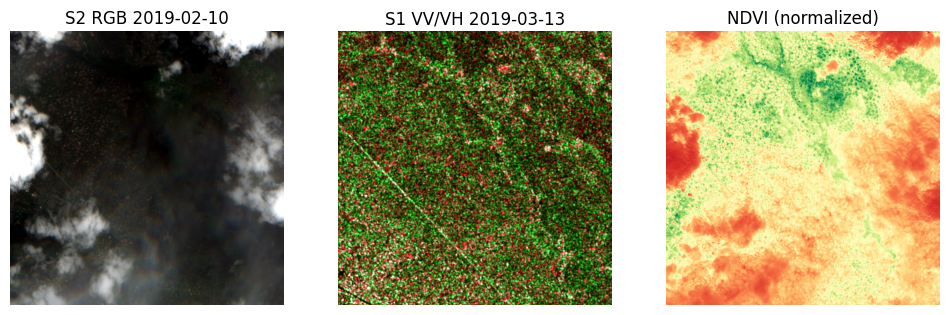

Patch: 0001


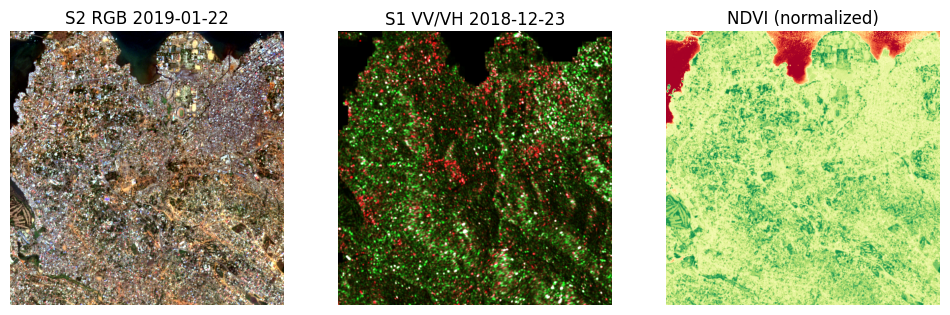

Patch: 0004


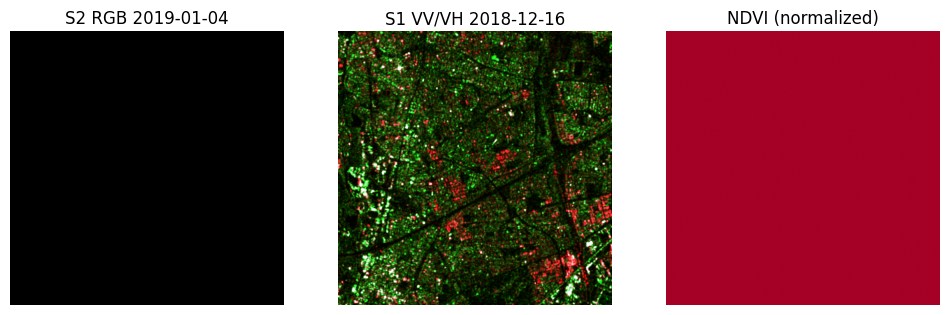

In [9]:
def visualize_patch(folder_id, thumb_size=512, show_ndvi=True):
    rows_s2 = df[(df.folder==folder_id) & (df.sensor=='S2')]
    rows_s1 = df[(df.folder==folder_id) & (df.sensor=='S1')]
    if len(rows_s2)==0:
        print('Aucune image S2 trouvée pour', folder_id); return
    if len(rows_s1)==0:
        print('Aucune image S1 trouvée pour', folder_id); return
    date_s2 = rows_s2.date.iloc[0] ### change 
    date_s1 = rows_s1.date.iloc[0] ###
    s2_rgb, b8 = load_s2_rgb(folder_id, date_s2, thumb_size=thumb_size)
    s1_img = load_s1(folder_id, date_s1, thumb_size=thumb_size)
    ndvi = None
    if show_ndvi and b8 is not None:
        ndvi = compute_ndvi_from_files(b4_path=str((root/folder_id)/f'S2_{date_s2}_B04.tif'), b8_path=str((root/folder_id)/f'S2_{date_s2}_B08.tif'), ref_path=str((root/folder_id)/f'S2_{date_s2}_B04.tif'), thumb_size=thumb_size)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(s2_rgb)
    plt.title(f'S2 RGB {date_s2}')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(s1_img)
    plt.title(f'S1 VV/VH {date_s1}')
    plt.axis('off')
    if ndvi is not None:
        plt.subplot(1,3,3)
        plt.imshow(ndvi, cmap='RdYlGn')
        plt.title('NDVI (normalized)')
        plt.axis('off')
    plt.show()

# Exemple: afficher 3 premiers patches (si disponibles)
for pid in sorted(df.folder.unique())[:3]:
    print('Patch:', pid)
    try:
        visualize_patch(pid, thumb_size=512)
    except Exception as e:
        print('Erreur pour', pid, e)


# 🌈 Sentinel-2 Bands for Flood Detection  

## 🌊 Which Sentinel-2 Bands Are Useful for Flood Detection?

Flood detection relies on analyzing how different surfaces absorb or reflect specific wavelengths.  
Here are the **most useful Sentinel-2 bands**:

### 🔹 **B03 – Green (560 nm)**
- Useful for **NDWI (water index)**
- Water strongly absorbs green → low values over water

### 🔹 **B04 – Red (665 nm)**
- Part of **NDVI** and RGB  
- Helps separate vegetation, soil, and water

### 🔹 **B08 – NIR (842 nm)**
- Near Infrared  
- Vegetation reflects strongly  
- Water absorbs almost everything → appears very dark  
- Crucial for NDVI and water detection

### 🔹 **B11 – SWIR1 (1610 nm)**  
### 🔹 **B12 – SWIR2 (2190 nm)**
- Short-Wave Infrared  
- Water absorbs SWIR very strongly → extremely dark pixels  
- Excellent for discriminating water vs. soil/vegetation  
- Very useful during floods

---

## 📌 Summary of Key Bands for Flood Mapping

| Band | Region | Why it helps detect water |
|------|--------|----------------------------|
| **B03 (Green)** | Visible | Water appears dark → used in NDWI |
| **B04 (Red)** | Visible | Water and vegetation appear dark |
| **B08 (NIR)** | Near Infrared | Water absorbs NIR → strong water indicator |
| **B11 (SWIR1)** | Shortwave IR | Water almost invisible in SWIR → very dark |
| **B12 (SWIR2)** | Shortwave IR | Strongest indicator of water surfaces |

---

## 🧠 Combined Indices for Flood Detection

Several indices are built using these bands:

### ✔ **NDVI = (NIR - Red) / (NIR + Red)**  
Vegetation index — floods often reduce NDVI.

### ✔ **NDWI = (Green - NIR) / (Green + NIR)**  
Water index — highlights water bodies.

### ✔ **MNDWI = (Green - SWIR1) / (Green + SWIR1)**  
Enhanced water index — excellent for flood mapping.

---

## 🎯 Why These Bands Matter for Flood Detection

Floodwater has a distinct spectral behavior:

- **Very low reflectance in Red, NIR, and SWIR**
- **Dark signatures in all water-sensitive bands**
- **Large changes before/after flood** in NDVI / NDWI

Using B04 along with B03, B08, B11, and B12 creates a powerful multispectral feature set for flood mapping and prediction.

## 5) Distributions de pixels (échantillonnage)
Pour éviter de charger les images complètes, on prend des fenêtres aléatoires (patches) et on agrège des histogrammes / percentiles.

In [10]:
import random
def sample_window(path, size=256, n_samples=20):
    with rasterio.open(path) as src:
        h, w = src.height, src.width
        samples = []
        for _ in range(n_samples):
            i = random.randint(0, max(0, h-size))
            j = random.randint(0, max(0, w-size))
            window = src.read(1, window=rasterio.windows.Window(j, i, size, size))
            samples.append(window.flatten())
    return np.concatenate(samples)

## 6) Extractions de métriques par patch (échantillonnage rapide)
Nous calculons des statistiques robustes (moyenne, std, p5, p95) sur une sélection de fenêtres pour chaque patch et sauvons les métriques dans un fichier Parquet pour analyse ultérieure.

In [11]:
def compute_patch_metrics(folder_id, n_windows=10, window_size=256, index_choice=1):
    rows_s2 = df[(df.folder==folder_id)&(df.sensor=='S2')]
    rows_s1 = df[(df.folder==folder_id)&(df.sensor=='S1')]
    metrics = {'folder': folder_id, 'index_choice': index_choice}

    # ---------------------------
    # SENTINEL-2 (B04)
    # ---------------------------
    b4_rows = rows_s2[rows_s2.band=='B04']

    if len(b4_rows) > 0:
        if index_choice < len(b4_rows):
            path_b4 = b4_rows.path.iloc[index_choice]
            s = sample_window(path_b4, size=window_size, n_samples=n_windows)
            metrics.update({
                's2_b04_mean': float(np.mean(s)),
                's2_b04_std':  float(np.std(s)),
                's2_b04_p5':   float(np.percentile(s,5)),
                's2_b04_p95':  float(np.percentile(s,95)),
                's2_b04_path': path_b4
            })
        else:
            metrics.update({'s2_b04_error': f'Index {index_choice} out of range (only {len(b4_rows)} rows)'})

    # ---------------------------
    # SENTINEL-1 (VV)
    # ---------------------------
    vv_rows = rows_s1[rows_s1.band=='VV']

    if len(vv_rows) > 0:
        if index_choice < len(vv_rows):
            path_vv = vv_rows.path.iloc[index_choice]
            s = sample_window(path_vv, size=window_size, n_samples=n_windows)
            metrics.update({
                's1_vv_mean': float(np.mean(s)),
                's1_vv_std':  float(np.std(s)),
                's1_vv_p5':   float(np.percentile(s,5)),
                's1_vv_p95':  float(np.percentile(s,95)),
                's1_vv_path': path_vv
            })
        else:
            metrics.update({'s1_vv_error': f'Index {index_choice} out of range (only {len(vv_rows)} rows)'})

    return metrics


out_rows = []
for pid in sorted(df.folder.unique())[:50]:  # limiter par défaut à 50 patches pour rapidité
    try:
        out_rows.append(compute_patch_metrics(pid, n_windows=6))
    except Exception as e:
        print('Erreur métriques pour', pid, e)
metrics_df = pd.DataFrame(out_rows)
metrics_df.head()

# Convert object columns to string (Parquet requirement)
for col in metrics_df.columns:
    if metrics_df[col].dtype == "object":
        metrics_df[col] = metrics_df[col].astype("string")

# Try saving
try:
    metrics_df.to_parquet('patch_metrics_sample.parquet', index=False)
    print('Saved patch_metrics_sample.parquet')
except Exception as e:
    print('Parquet write failed:', e)
    print('Falling back to CSV. To enable Parquet output, install pyarrow or fastparquet:')
    print('  pip install pyarrow')
    metrics_df.to_csv('patch_metrics_sample.csv', index=False)
    print('Saved patch_metrics_sample.csv')


Saved patch_metrics_sample.parquet


In [12]:
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm

# ---------------------------
# SAFE HELPERS
# ---------------------------

def safe_iloc(rows, index_choice):
    """Return a valid row. If index out of range → fallback to first row."""
    if len(rows) == 0:
        return None
    if index_choice >= len(rows):
        return rows.iloc[0]
    return rows.iloc[index_choice]


def safe_read_window(path, size, n_samples):
    """Safely read random windows from a raster file."""
    try:
        with rasterio.open(path) as src:
            h, w = src.height, src.width
            windows = []

            for _ in range(n_samples):
                i = np.random.randint(0, max(1, h - size))
                j = np.random.randint(0, max(1, w - size))

                win = rasterio.windows.Window(j, i, size, size)
                arr = src.read(1, window=win)

                # avoid empty windows
                if arr.size == 0:
                    continue

                windows.append(arr.flatten())

            if len(windows) == 0:
                return None

            return np.concatenate(windows)

    except Exception as e:
        print("Error reading:", path, e)
        return None


def compute_stats(arr):
    """Compute stats safely for an array of pixel values."""
    if arr is None or arr.size == 0:
        return {
            "mean": np.nan,
            "std": np.nan,
            "p5": np.nan,
            "p95": np.nan
        }

    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "p5": float(np.percentile(arr, 5)),
        "p95": float(np.percentile(arr, 95))
    }


# ---------------------------
# MAIN FUNCTION
# ---------------------------

def compute_patch_metrics(folder_id, df, n_windows=10, window_size=256, index_choice=0):
    """Compute S1+S2 metrics for one geographical patch."""
    metrics = {"folder": folder_id, "index_choice": index_choice}

    rows_s2 = df[(df.folder == folder_id) & (df.sensor == 'S2')]
    rows_s1 = df[(df.folder == folder_id) & (df.sensor == 'S1')]

    # ---------------------------
    # SENTINEL-2 B04
    # ---------------------------
    b4_rows = rows_s2[rows_s2.band == 'B04']
    b4_row = safe_iloc(b4_rows, index_choice)

    if b4_row is not None:
        path_b4 = b4_row.path
        arr_b4 = safe_read_window(path_b4, window_size, n_windows)
        stats_b4 = compute_stats(arr_b4)

        metrics.update({
            "s2_b04_mean": stats_b4["mean"],
            "s2_b04_std": stats_b4["std"],
            "s2_b04_p5": stats_b4["p5"],
            "s2_b04_p95": stats_b4["p95"],
            "s2_b04_path": str(path_b4)
        })
    else:
        metrics["s2_missing"] = True

    # ---------------------------
    # SENTINEL-1 VV
    # ---------------------------
    vv_rows = rows_s1[rows_s1.band == 'VV']
    vv_row = safe_iloc(vv_rows, index_choice)

    if vv_row is not None:
        path_vv = vv_row.path
        arr_vv = safe_read_window(path_vv, window_size, n_windows)
        stats_vv = compute_stats(arr_vv)

        metrics.update({
            "s1_vv_mean": stats_vv["mean"],
            "s1_vv_std": stats_vv["std"],
            "s1_vv_p5": stats_vv["p5"],
            "s1_vv_p95": stats_vv["p95"],
            "s1_vv_path": str(path_vv)
        })
    else:
        metrics["s1_missing"] = True

    return metrics


# ---------------------------
# RUN PIPELINE ON ALL PATCHES
# ---------------------------

all_metrics = []

print("Computing metrics for all patches...")

for folder_id in tqdm(sorted(df.folder.unique())):
    try:
        m = compute_patch_metrics(folder_id, df, n_windows=8, window_size=256, index_choice=0)
        all_metrics.append(m)
    except Exception as e:
        print("Error in patch", folder_id, e)

metrics_df = pd.DataFrame(all_metrics)

# ---------------------------
# SAVE AS PARQUET (CLEAN STRINGS)
# ---------------------------

for col in metrics_df.columns:
    if metrics_df[col].dtype == "object":
        metrics_df[col] = metrics_df[col].astype("string")

try:
    metrics_df.to_parquet("SEN12FLOOD_patch_metrics.parquet", index=False)
    print("\nSaved: SEN12FLOOD_patch_metrics.parquet")
except Exception as e:
    print("Parquet save error:", e)
    metrics_df.to_csv("SEN12FLOOD_patch_metrics.csv", index=False)
    print("\nSaved: SEN12FLOOD_patch_metrics.csv")


Computing metrics for all patches...


100%|██████████| 44/44 [00:04<00:00, 10.52it/s]


Saved: SEN12FLOOD_patch_metrics.parquet


## 7) Conclusions & interpretation
- Displaying S2 (RGB) and S1 (VV/VH) side-by-side helps identify water even under cloud cover (S1).
- NDVI helps distinguish vegetation/soil/water; very low NDVI often indicates water or bare soil.
- Histograms/percentiles per patch provide a sense of value ranges and help define robust thresholds for simple heuristics.

### Next steps:
- Build multi-temporal features (time series) per patch.
- Use these metrics to train a classifier (e.g. RandomForest) or a neural network by extracting regular tiles.
- Use Dask / rasterio windows for a scalable pipeline if you need to process the full dataset (~18 GB).

## 8) Compute spectral indices: NDVI, NDWI, MNDWI

Below we provide functions to compute the common indices used in flood detection:
- NDVI = (NIR - Red) / (NIR + Red)
- NDWI = (Green - NIR) / (Green + NIR)
- MNDWI = (Green - SWIR1) / (Green + SWIR1)

Each function accepts either file paths (they will be aligned to a reference band) or NumPy arrays. The results are returned normalized to [-1,1] for analysis and optionally to [0,1] for display.

In [13]:
def _safe_index(a, b):
    # a and b are float arrays; compute (a-b)/(a+b) safely
    a = a.astype('float32')
    b = b.astype('float32')
    denom = (a + b).astype('float32')
    # avoid division by zero
    denom[denom == 0] = np.nan
    idx = (a - b) / denom
    idx = np.nan_to_num(idx, nan=0.0)
    return idx

def compute_index_from_arrays(numerator, denominator, normalize_for_display=False):
    # numerator and denominator are arrays representing the two bands used in the index
    idx = _safe_index(numerator, denominator)
    if normalize_for_display:
        # map from [-1,1] to [0,1] for visualization
        return np.clip((idx + 1.0) / 2.0, 0.0, 1.0)
    return idx

def compute_ndvi_from_files(red_path, nir_path, ref_path=None, thumb_size=None, display=False):
    # NDVI = (NIR - Red) / (NIR + Red)
    if ref_path is None:
        ref_path = red_path
    R = align_band(ref_path, red_path)
    N = align_band(ref_path, nir_path)
    idx = _safe_index(N, R)
    if thumb_size is not None:
        vis = np.clip((idx + 1.0) / 2.0, 0.0, 1.0)
        img_uint8 = (vis * 255).astype('uint8')
        pil = Image.fromarray(img_uint8)
        pil = pil.resize((thumb_size, thumb_size), resample=Image.BILINEAR)
        vis = np.asarray(pil).astype('float32') / 255.0
        return idx, vis if display else idx
    return (np.clip((idx + 1.0) / 2.0, 0.0, 1.0) if display else idx)

def compute_ndwi_from_files(green_path, nir_path, ref_path=None, thumb_size=None, display=False):
    # NDWI = (Green - NIR) / (Green + NIR)
    if ref_path is None:
        ref_path = green_path
    G = align_band(ref_path, green_path)
    N = align_band(ref_path, nir_path)
    idx = _safe_index(G, N)
    if thumb_size is not None:
        vis = np.clip((idx + 1.0) / 2.0, 0.0, 1.0)
        img_uint8 = (vis * 255).astype('uint8')
        pil = Image.fromarray(img_uint8)
        pil = pil.resize((thumb_size, thumb_size), resample=Image.BILINEAR)
        vis = np.asarray(pil).astype('float32') / 255.0
        return idx, vis if display else idx
    return (np.clip((idx + 1.0) / 2.0, 0.0, 1.0) if display else idx)

def compute_mndwi_from_files(green_path, swir1_path, ref_path=None, thumb_size=None, display=False):
    # MNDWI = (Green - SWIR1) / (Green + SWIR1)
    if ref_path is None:
        ref_path = green_path
    G = align_band(ref_path, green_path)
    S = align_band(ref_path, swir1_path)
    idx = _safe_index(G, S)
    if thumb_size is not None:
        vis = np.clip((idx + 1.0) / 2.0, 0.0, 1.0)
        img_uint8 = (vis * 255).astype('uint8')
        pil = Image.fromarray(img_uint8)
        pil = pil.resize((thumb_size, thumb_size), resample=Image.BILINEAR)
        vis = np.asarray(pil).astype('float32') / 255.0
        return idx, vis if display else idx
    return (np.clip((idx + 1.0) / 2.0, 0.0, 1.0) if display else idx)

Using patch 0
Files exist (B02,B03,B04,B08,B11): True True True True True


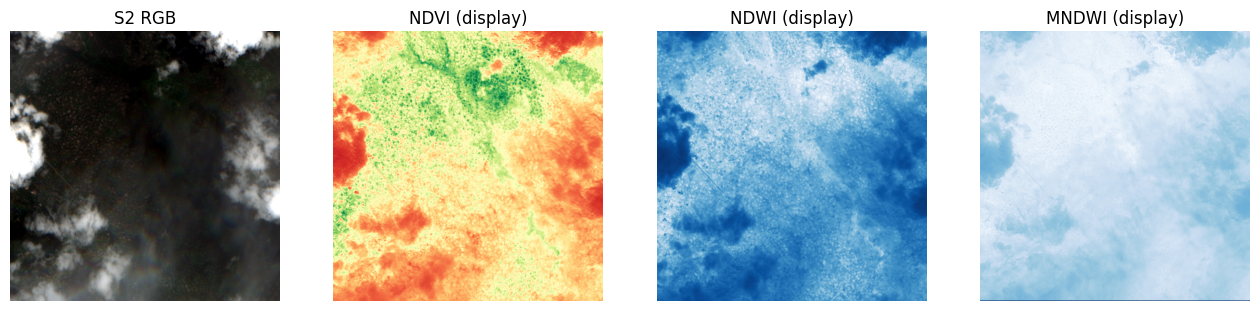

In [14]:
# Example: compute and display NDVI / NDWI / MNDWI for the first available S2 patch
def show_indices_for_first_patch(thumb_size=512):
    patches = sorted(df.folder.unique())
    if len(patches) == 0:
        print('No patches found in df')
        return
    pid = patches[0]
    print('Using patch', pid)
    rows_s2 = df[(df.folder==pid)&(df.sensor=='S2')]
    if rows_s2.empty:
        print('No S2 images for', pid); return
    date = rows_s2.date.iloc[0]
    folder = root / pid
    # expected band paths (may not all exist in every patch)
    b02 = folder / f'S2_{date}_B02.tif'
    b03 = folder / f'S2_{date}_B03.tif'
    b04 = folder / f'S2_{date}_B04.tif'
    b08 = folder / f'S2_{date}_B08.tif'
    b11 = folder / f'S2_{date}_B11.tif'
    print('Files exist (B02,B03,B04,B08,B11):', b02.exists(), b03.exists(), b04.exists(), b08.exists(), b11.exists())
    # Load RGB (if available)
    try:
        rgb, _ = load_s2_rgb(pid, date, thumb_size=thumb_size)
    except Exception as e:
        print('Could not load RGB:', e)
        rgb = None
    # helper to call index functions safely (they may raise if files missing)
    def safe_call(f, *args, **kw):
        try:
            return f(*args, **kw)
        except Exception as e:
            print('Index computation failed:', e)
            return None
    ndvi = safe_call(compute_ndvi_from_files, str(b04), str(b08), ref_path=str(b04), thumb_size=thumb_size, display=True) if b04.exists() and b08.exists() else None
    ndwi = safe_call(compute_ndwi_from_files, str(b03), str(b08), ref_path=str(b04), thumb_size=thumb_size, display=True) if b03.exists() and b08.exists() else None
    mndwi = safe_call(compute_mndwi_from_files, str(b03), str(b11), ref_path=str(b04), thumb_size=thumb_size, display=True) if b03.exists() and b11.exists() else None
    # un-pack results (functions return either idx or (idx, vis) when display=True)
    def unpack(x):
        if x is None: return (None, None)
        if isinstance(x, tuple): return x
        return (x, None)
    ndvi_idx, ndvi_vis = unpack(ndvi)
    ndwi_idx, ndwi_vis = unpack(ndwi)
    mndwi_idx, mndwi_vis = unpack(mndwi)
    import matplotlib.pyplot as plt
    # build a flexible layout depending on which images are available
    panes = []
    if rgb is not None: panes.append((rgb, 'S2 RGB', None))
    if ndvi_vis is not None: panes.append((ndvi_vis, 'NDVI (display)', 'RdYlGn'))
    if ndwi_vis is not None: panes.append((ndwi_vis, 'NDWI (display)', 'Blues'))
    if mndwi_vis is not None: panes.append((mndwi_vis, 'MNDWI (display)', 'Blues'))
    if len(panes) == 0:
        print('No imagery or index displays available for this patch')
        return
    plt.figure(figsize=(4*len(panes),4))
    for i, (img, title, cmap) in enumerate(panes, start=1):
        plt.subplot(1, len(panes), i)
        if cmap is None:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Run the example (will execute when you run this cell locally)
show_indices_for_first_patch(thumb_size=512)